# Energy-Based models and structured prediction

In this assignment we're going to work with structured prediction. Structured prediction broadly refers to any problem involving predicting structured values, as opposed to plain scalars. Examples of structured outputs include graphs and text.

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [1]:
#! mkdir -p fonts
#! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
#! unzip -n fonts/font.zip -d fonts

In [2]:
from functools import partial
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont # PIL is a library to process images
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from tqdm.notebook import tqdm

import gc
import numpy as np
import os
import random
import string
import torch

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

torch.Size([32, 18])


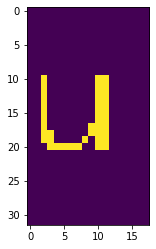

In [5]:
simple_transforms = transforms.Compose([
                                    transforms.ToTensor(), 
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, length=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.length = length
    self.jitter = jitter
    self.noise = noise
  
  def __len__(self):
    return self.length

  def __iter__(self):
    for _ in range(self.length):
        text = ''.join([random.choice(string.ascii_lowercase)\
          for _ in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text
  
  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1 
    
    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)

    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img = next(iter(sds))[0]
print(img.shape)
plt.imshow(img)

We can look at what the entire alphabet looks like in this dataset.

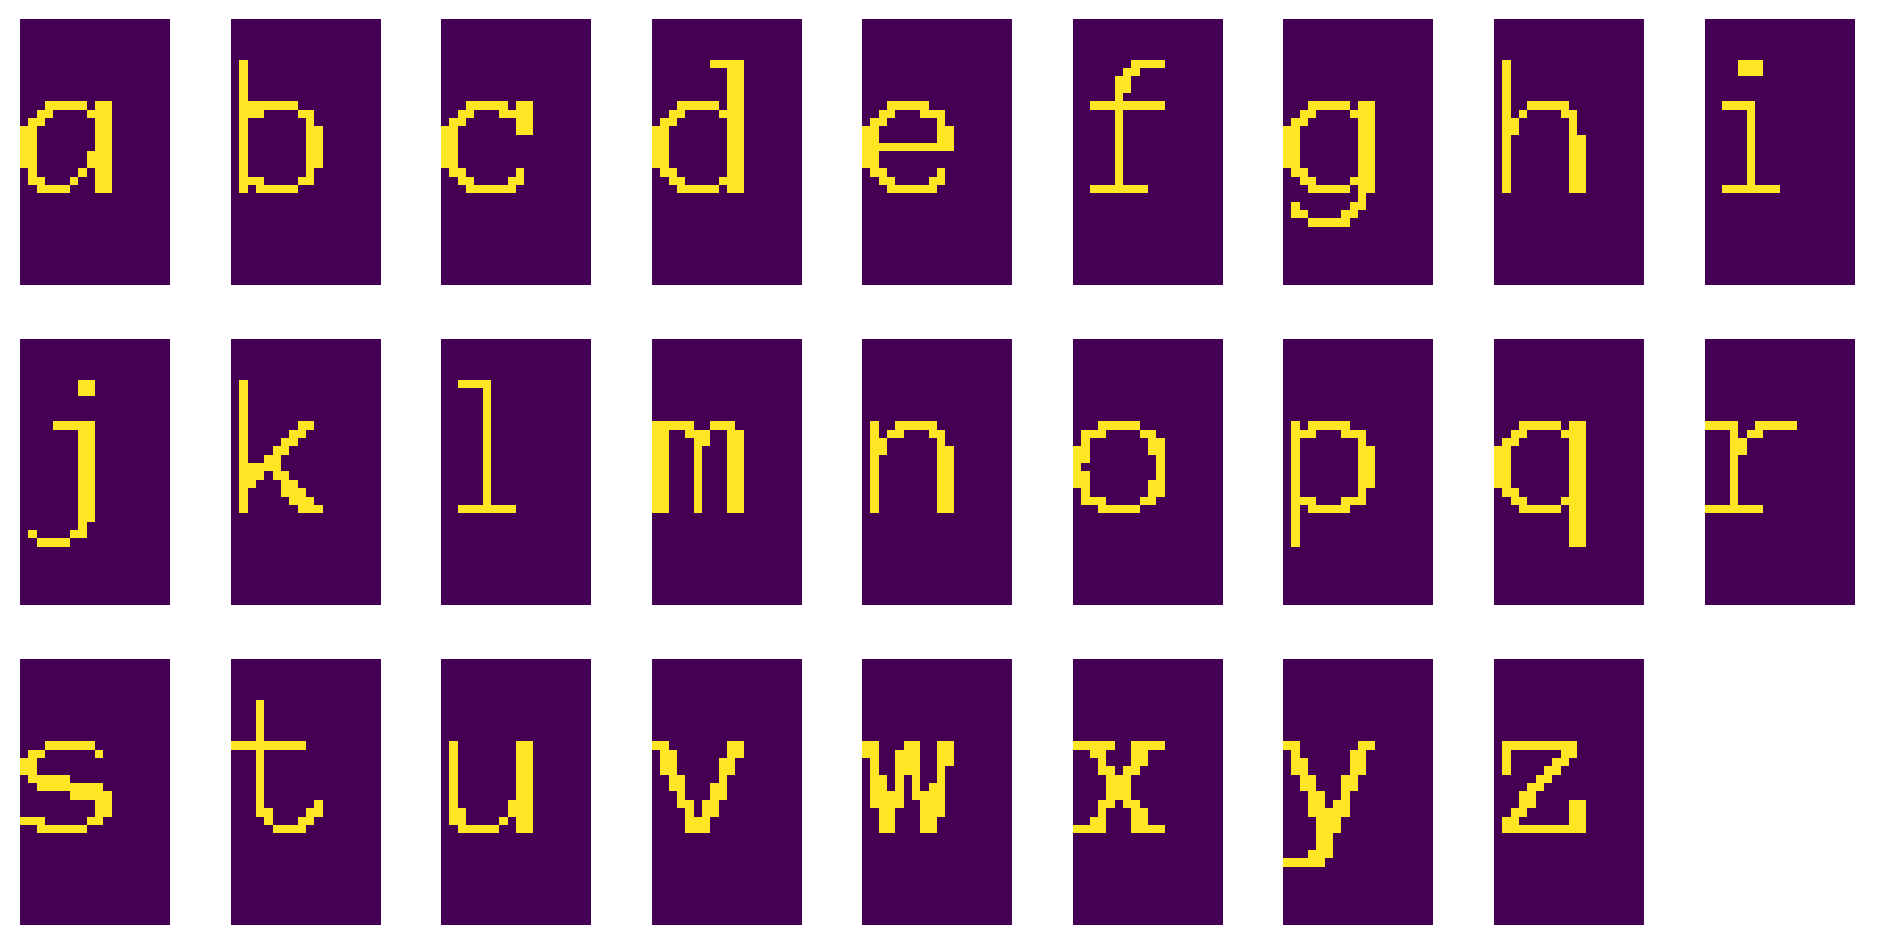

In [6]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')
    
plt.show()

We can also put the entire alphabet in one image.

(-0.5, 339.5, 31.5, -0.5)

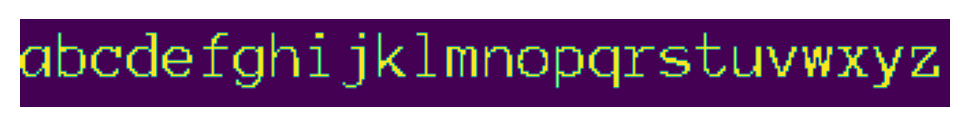

In [7]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things. 
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [8]:
alphabet.shape

torch.Size([32, 340])

In [9]:
alphabet.view(1, 1, *alphabet.shape).shape

torch.Size([1, 1, 32, 340])

In [10]:
# constants for number of classes in total, and for the special extra character 
# for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [11]:
class SimpleNet(nn.Module):

    def __init__(self, img_height=32, kernel_width=18, width_stride=6):
        super().__init__()
        self.n_features = ALPHABET_SIZE
        divisor = 1
        self.kernel_height = (img_height + divisor - 1) // divisor
        self.kernel_width = (kernel_width + divisor - 1) // divisor
        self.height_padding = 0
        self.width_padding = 0 #kernel_width // 2
        self.height_stride = (img_height + divisor -1) // divisor
        self.width_stride = (width_stride + divisor - 1) // divisor
        layer_1_kernel = 3
        layer_1_padding = layer_1_kernel // 2
        layer_1_stride = 1
        self.cnn_block = nn.Sequential(
          nn.Conv2d(
            in_channels=1, out_channels=self.n_features // 4,
            kernel_size=layer_1_kernel, padding=layer_1_padding,
            stride = layer_1_stride
          ),
          nn.ReLU(),
          nn.Conv2d(
            in_channels=self.n_features // 4, out_channels=self.n_features // 2,
            kernel_size=layer_1_kernel, padding=layer_1_padding,
            stride = layer_1_stride
          ),
          nn.ReLU(),
          nn.Conv2d(
            in_channels=self.n_features // 2, out_channels=self.n_features,
            kernel_size=(self.kernel_height, self.kernel_width),
            padding=(self.height_padding, self.width_padding),
            stride=(self.height_stride, self.width_stride)),
          # nn.ReLU(),
          # nn.Conv2d(
          #   in_channels=self.n_features, out_channels=self.n_features,
          #   kernel_size=1),
          #nn.ReLU(),
        )

    def forward(self, x):
        x = self.cnn_block(x)
        # after applying cnn_block, x.shape should be:
        # batch_size, alphabet_size, 1, width
        # print(x.shape)
        x = x[:, :, 0, :].permute(0, 2, 1)
        return x

Let's initalize the model and apply it to the alphabet image:

SimpleNet(
  (cnn_block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(13, 27, kernel_size=(32, 15), stride=(32, 6))
  )
)
torch.Size([1, 55, 27])


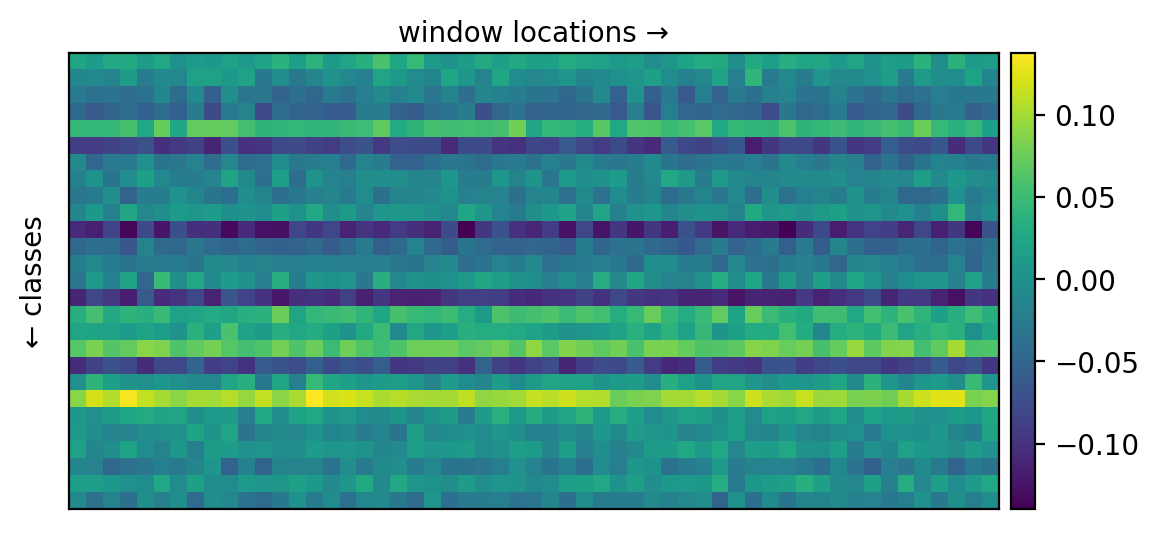

In [51]:
model = SimpleNet(kernel_width=15, width_stride=6)
if torch.cuda.is_available():
    model = model.cuda()
print(model)
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape).to(device))
print(alphabet_energies.shape)

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(ce.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    cax = fig.add_axes(
        [ ax.get_position().x1 + 0.01, 
          ax.get_position().y0, 0.02, ax.get_position().height] )
    plt.colorbar(im, cax=cax) 
    
plot_energies(alphabet_energies[0].detach())

torch.Size([32, 130])
Num positions: 20
tensor([14, 10, 14, 10, 18, 10, 14, 10, 14, 10, 10, 10, 10, 14, 14, 14, 10, 14,
        10, 14], device='cuda:0')


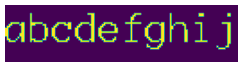

In [52]:
min_alph = sds.draw_text(string.ascii_lowercase[0:10], 130)
plt.figure(dpi=50)
plt.imshow(min_alph)
plt.axis('off')
print(min_alph.shape)
min_alph_energies = model(min_alph.view(1, 1, *min_alph.shape).to(device))
positions = min_alph_energies[0].argmin(dim=1)
print(f'Num positions: {len(positions)}\n{positions}')

In [101]:
for idx, letter in enumerate(string.ascii_lowercase):
    alph = sds.draw_text(letter, 18)
    alph_energies = model(alph.view(1, 1, *alph.shape).to(device))
    res = alph_energies[0].argmin(dim=1)
    match = idx == res.item()
    print(f'Letter: {letter} idx: {idx} res: {res.item()} idx match: {match}')

Letter: a idx: 0 res: 0 idx match: True
Letter: b idx: 1 res: 1 idx match: True
Letter: c idx: 2 res: 2 idx match: True
Letter: d idx: 3 res: 3 idx match: True
Letter: e idx: 4 res: 4 idx match: True
Letter: f idx: 5 res: 5 idx match: True
Letter: g idx: 6 res: 6 idx match: True
Letter: h idx: 7 res: 7 idx match: True
Letter: i idx: 8 res: 8 idx match: True
Letter: j idx: 9 res: 9 idx match: True
Letter: k idx: 10 res: 10 idx match: True
Letter: l idx: 11 res: 11 idx match: True
Letter: m idx: 12 res: 12 idx match: True
Letter: n idx: 13 res: 13 idx match: True
Letter: o idx: 14 res: 14 idx match: True
Letter: p idx: 15 res: 15 idx match: True
Letter: q idx: 16 res: 16 idx match: True
Letter: r idx: 17 res: 17 idx match: True
Letter: s idx: 18 res: 18 idx match: True
Letter: t idx: 19 res: 19 idx match: True
Letter: u idx: 20 res: 20 idx match: True
Letter: v idx: 21 res: 21 idx match: True
Letter: w idx: 22 res: 22 idx match: True
Letter: x idx: 23 res: 23 idx match: True
Letter: y id

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [54]:
def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    # print(f'Samples shape: {len(samples)}')
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(
        map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(
            images[i], (0, m_width - images[i].shape[-1]))
        
    if len(images) == 1:
        input, target = images[0].unsqueeze(0), torch.stack(annotations)
    else:
        input, target = torch.stack(images), torch.stack(annotations)
    input.unsqueeze_(1)
    target = F.one_hot(target, num_classes=ALPHABET_SIZE)
    target = target.to(torch.float32)
    # print(f'Shape input: {input.shape} target: {target.shape}')    
    return input, target

In [55]:
def get_correct_simple(output, target):
    pred = (output.argmin(dim=1) == target.argmax(dim=1)).to(
        torch.float).cpu().mean()
    return pred

def get_loss_and_correct_simple(
    device, criterion, accuracy, model, batch, acc_thresh=0.5):
    data, target = batch
    data, target = data.to(device), target.to(device)
    output = model(data)
    output.squeeze_()
    loss = criterion(output, target)
    pred = accuracy(output, target)
    return loss, pred
    
def step(loss, optimizer, scheduler=None):
    optimizer.zero_grad()
    loss.backward()
    if scheduler:
        optimizer.step()
        scheduler.step()
    else:
        optimizer.step()

In [56]:
def train(
    num_epochs, model, data_loader, optimizer, scheduler, get_loss_and_correct):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    pbar = tqdm(range(num_epochs))
    for i in pbar:
        total_train_loss = []
        total_train_correct = []
        total_validation_loss = []
        total_validation_correct = []

        model.train()

        for batch in tqdm(data_loader, leave=False):
            loss, correct = get_loss_and_correct(model, batch)
            step(loss, optimizer, scheduler)
            total_train_loss.append(loss)
            total_train_correct.append(correct)

        mean_train_loss = torch.FloatTensor(total_train_loss).mean().item()
        train_accuracy = torch.FloatTensor(total_train_correct).mean().item()
        print(f'Iteration {i} loss: {mean_train_loss} accuracy: {train_accuracy}')
        pbar.set_postfix(
            { 'train_loss': mean_train_loss, 
            'train_accuracy': train_accuracy, 
            }
        )


In [57]:
N_EPOCHS = 10
BATCH_SIZE = 64
NUM_BATCHES = 32

sds = SimpleWordsDataset(
    1, length=BATCH_SIZE * NUM_BATCHES, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(
    sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=simple_collate_fn)

# TODO: train the model on the one-character dataset

# criterion = nn.BCEWithLogitsLoss()

lr = 1e-4
optimizer = torch.optim.Adam(
  model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8, weight_decay=0.01,
  amsgrad=False, 
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
  optimizer, steps_per_epoch=len(dataloader), epochs=N_EPOCHS,
  max_lr=1e-3, div_factor=1e2, final_div_factor=1e3,
  anneal_strategy='cos',
  cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,
  three_phase=False, last_epoch=-1,
  verbose=False, 
)

gc.collect()
torch.cuda.empty_cache()

loss_and_correct_func = partial(
  get_loss_and_correct_simple, device, cross_entropy, get_correct_simple)
train(
  N_EPOCHS, model, dataloader, optimizer, scheduler, loss_and_correct_func)
  

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 0 loss: 3.2848727703094482 accuracy: 0.05078125


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 1 loss: 3.096820831298828 accuracy: 0.1826171875


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 2 loss: 1.6057217121124268 accuracy: 0.677734375


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 3 loss: 0.29734185338020325 accuracy: 0.958984375


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 4 loss: 0.09262757748365402 accuracy: 0.99658203125


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 5 loss: 0.05710037425160408 accuracy: 0.99609375


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 6 loss: 0.03960361331701279 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 7 loss: 0.032959792762994766 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 8 loss: 0.031969234347343445 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 9 loss: 0.030222827568650246 accuracy: 1.0


In [102]:
def get_accuracy(model, dataset):
    cnt = 0
    for i, l in dataset:
        energies = model(i.unsqueeze(0).unsqueeze(0).cuda())[0, 0]
        x = energies.argmin(dim=-1)
        cnt += int(x == (ord(l[0]) - ord('a')))
    return cnt / len(dataset)
        
tds = SimpleWordsDataset(1, length=100)
assert get_accuracy(model, tds) == 1.0,\
    'Your model doesn\'t achieve 100% accuracy for 1 character'

Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

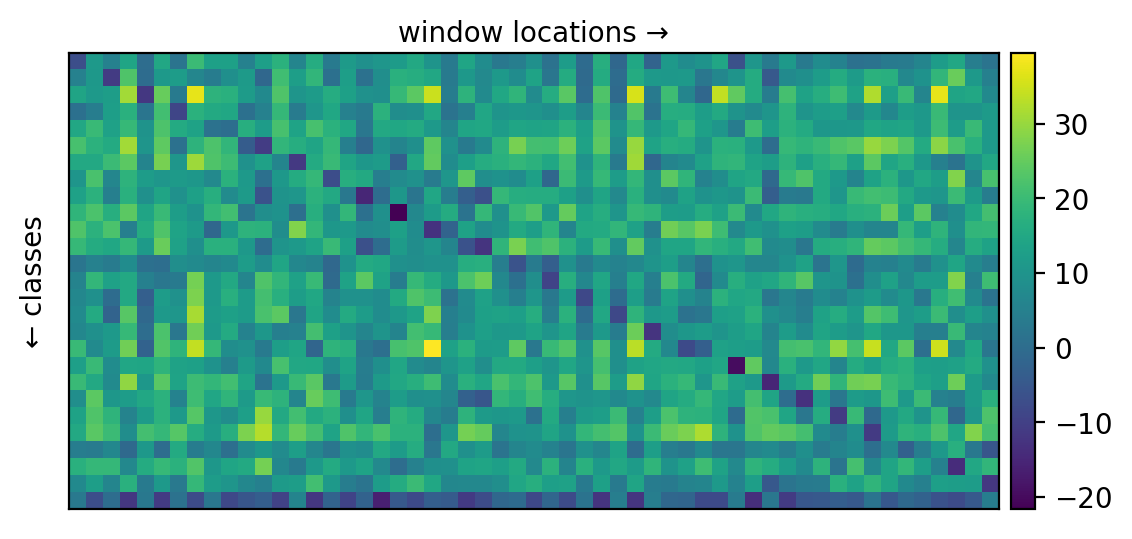

In [103]:
alphabet_energies_post_train = model(
    alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())

In [104]:
print(alphabet_energies_post_train.shape)

torch.Size([1, 55, 27])


Explain any classes that are lit up. What is still missing to be able to use it for transcription of words?

Answer: #TODO

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [61]:
def build_path_matrix(device, energies, targets):
    # inputs: 
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #
    # Note: you're not allowed to use for loops. The calculation has to be
    # vectorized. You may want to use repeat and repeat_interleave.

    # Turn target into one hot encoding
    # BS X T X 27
    targ_one_hot = F.one_hot(targets, num_classes=ALPHABET_SIZE).to(torch.float)

    # transpose axis for matrix multiplication
    # BS X 27 X T
    targ_one_hot = torch.transpose(targ_one_hot, 1, 2)

    # Filter out expected labels
    # BS X L X T
    targ_one_hot = targ_one_hot.to(device)
    target_energies = energies @ targ_one_hot
    return target_energies

def build_ce_matrix(device, energies, targets):
    # inputs: 
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    # 
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #
    # Note: you're not allowed to use for loops. The calculation has to be
    # vectorized.
    # you may want to use repeat and repeat_interleave.
    batch_size_e, window_size, alph_size  = energies.shape
    batch_size_t, word_len = targets.shape
    assert batch_size_e == batch_size_t
    batch_size = batch_size_e
    
    # BS X L X 1 (will leverage on broadcasting on the next step)
    energies_exp_sum = energies.mul(-1).logsumexp(dim=2, keepdim=True)
    repeat_tensor = torch.tensor(alph_size).to(device)

    # BS X L X 27
    energies_cross = energies + energies_exp_sum
    return build_path_matrix(device, energies_cross, targets)

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '_' models the separation between words, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc). 
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [62]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    tmp = '_'.join(s) + '_'
    tmp = [ord(char) - ord('a') if char != '_' else 26 for char in tmp]
    tmp = torch.tensor(tmp)
    assert torch.max(tmp) == BETWEEN
    return tmp

Now, let's plot energy table built on our model's prediction for alphabet image.

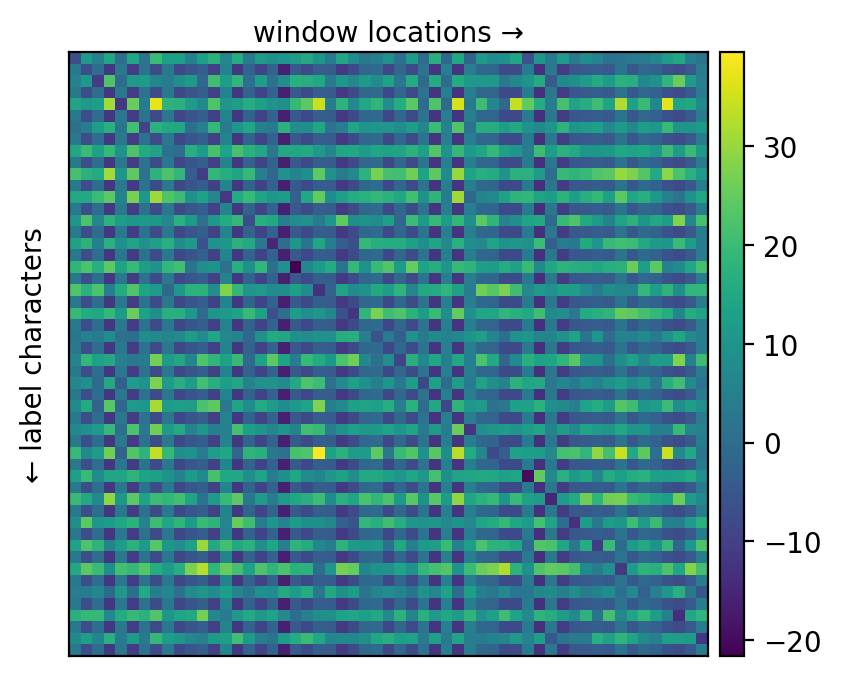

In [105]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)
    
    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([])
    ax.set_yticks([])
    
    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(
                *path[i], *path[i+1], marker = 'o', markersize=0.5,
                linewidth=10, color='r', alpha=1)

    cax = fig.add_axes(
        [ ax.get_position().x1 + 0.01,ax.get_position().y0,
          0.02,ax.get_position().height ])
    plt.colorbar(im, cax=cax) 
    
energies = model(alphabet.cuda().view(1, 1, *alphabet.shape))
targets = transform_word(string.ascii_lowercase).unsqueeze(0)

pm = build_path_matrix(device, energies, targets)
plot_pm(pm[0].detach())

What do you see? What does the model classify correctly, and what does it have problems with?

Answer: #TODO

Searching for a good pairing $z$ is same as searching for a trajectory with a small sum of it's values in this `pm` matrix. Where does the trajectory start, and where does it end? What other properties does the trajectory have? Can you see where an optimal trajecotry would be passing through in the plot above?

Answer: #TODO

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [64]:
def path_energy(device, pm, path):
    # inputs:
    #   pm - a matrix of energies 
    #    L - energies length
    #    T - targets length
    #   path - list of length L that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid
    
    # add batch dimension if not present
    if len(pm.shape) == 2:
        pm = pm[None]
    B, L, T = pm.shape
    if not isinstance(path, torch.Tensor):
        z = torch.tensor(path).to(device)
    else:
        z = path

    # add batch dimension to z
    # B X L
    if len(z.shape) == 1:
        z = z[None]

    assert B == z.shape[0]

    # Extra penalize term
    mask = torch.zeros(1, L).to(device)
    mask[0, 0] = 1
    mask[0, L-1] = 1

    first_last = z * mask
    mask[0, 0] = 0
    mask[0, L-1] = T - 1

    # make sure first and last terms matched are the first and last characters
    # in the text
    first_last = (first_last - mask).abs().sum(dim=1)
    diff = z[:, :L-1] - z[:, 1:]
    # make sure all entries of the path are either monotonically increasing
    # or staying constant
    # diff > 0 == max(diff, 0)
    # diff < -1 == max(-diff-1, 0)
    monotonic = (F.relu(diff) + F.relu(-diff-1)).sum(dim=1)
    c_z = ((first_last + monotonic) * torch.tensor(2**30).to(device))

    # extract the path values for each path in a batch
    indices = F.one_hot(z.to(int), num_classes=T).to(device)
    path_values = pm * indices

    mask = indices.float().masked_fill(indices==0, torch.inf)
    mask = mask.masked_fill(indices==1, 0)
    # z = path_values.nonzero()[:1]
    path_values = path_values + mask
    path_values_min, idxs = path_values.min(dim=2)

    ret = c_z + path_values_min.sum(dim=1)
    return ret, path_values_min

Now we can check some randomly generated paths and see the associated energies for our alphabet image:

energy is -293.739501953125


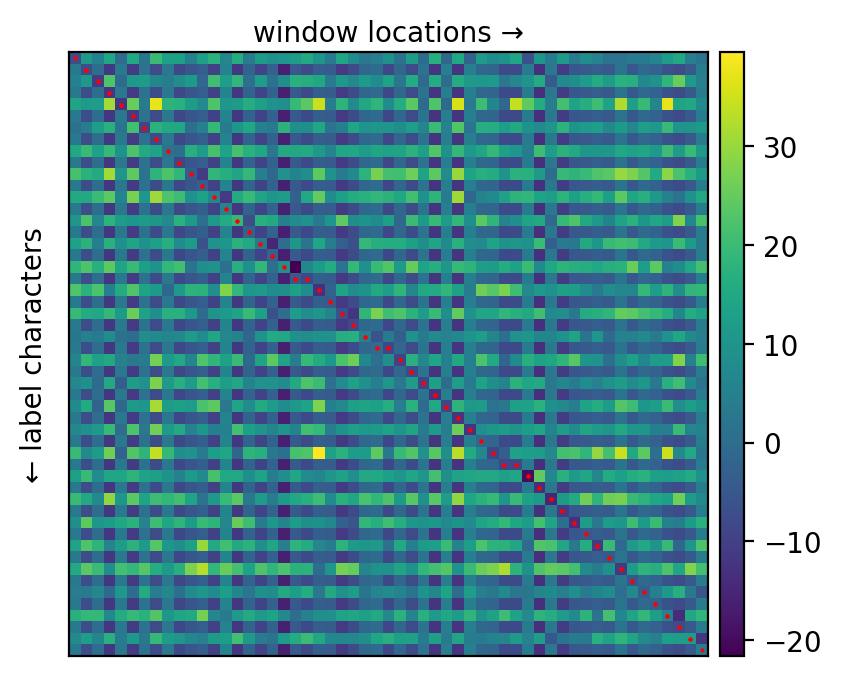

In [106]:
path = torch.zeros(energies.shape[1] - 1)
path[:targets.shape[1] - 1] = 1
path = [0] + list(
    map(lambda x : x.int().item(),
        path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(device, pm, path)[0].item())

Now, generate two paths with the worst possible energy, print their energies and plot them.

In [66]:
# TODO

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.

Below, you'll need to implement this algorithm:

In [67]:
def find_path(device, pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix 
    #         3. the dp array

    L, T = pm.shape
    dp_array = torch.zeros(L, T).to(device)
    dp_array[0, 0] = pm[0,0]

    for i in range(1, L):
        dp_array[i, 0] = pm[i, 0] + dp_array[i - 1, 0]

    dp_array[0, 1:T] = 2 ** 30

    for i in range(1, L):
        less_than = (dp_array[i-1, 1:T] < dp_array[i-1, 0:T-1])
        more_than = less_than.logical_not()
        dp_array[i, 1:T] += dp_array[i-1, 1:T] * less_than.to(torch.float)
        dp_array[i, 1:T] += dp_array[i-1, 0:T-1] * more_than.to(torch.float)
        dp_array[i, 1:T] += pm[i, 1:T]

    j = T-1
    path = torch.zeros(L, dtype=torch.int).to(device)
    path[0] = 0
    path[L-1] = T-1
    for i in range(L-2, 0, -1):
        next_j = max(j-1, 0)
        if dp_array[i][j] < dp_array[i][next_j]:
            path[i] = j
        else:
            j = next_j
            path[i] = j

    total_energy = dp_array[i, j]
    return total_energy, path, dp_array


Let's take a look at the best path:

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 21), (24, 22), (25, 23), (26, 24), (27, 25), (28, 26), (29, 27), (30, 28), (31, 29), (32, 30), (33, 31), (34, 32), (35, 33), (36, 34), (37, 35), (38, 35), (39, 36), (40, 37), (41, 38), (42, 39), (43, 40), (44, 41), (45, 42), (46, 43), (47, 44), (48, 45), (49, 46), (50, 47), (51, 48), (52, 49), (53, 50), (54, 51)]
free energy is -13.922917366027832


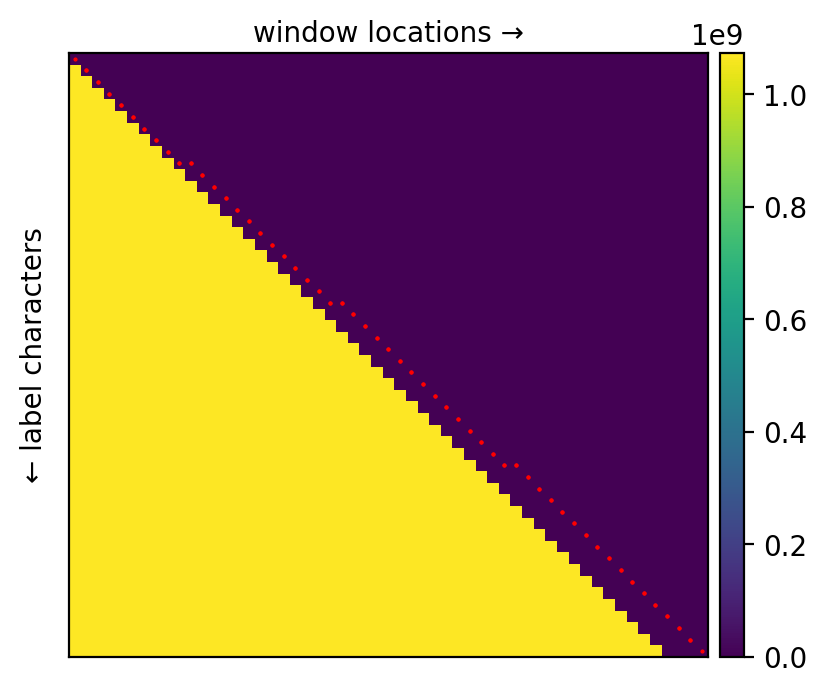

In [107]:
free_energy, path, d = find_path(device, pm[0])
points = [(i, v.item()) for i, v in enumerate(path)]
print(points)
plot_pm(d.detach(), points)
print('free energy is', free_energy.item())

We can also visualize the dp array. You may need to tune clamping to see what it looks like.

(-0.5, 54.5, 51.5, -0.5)

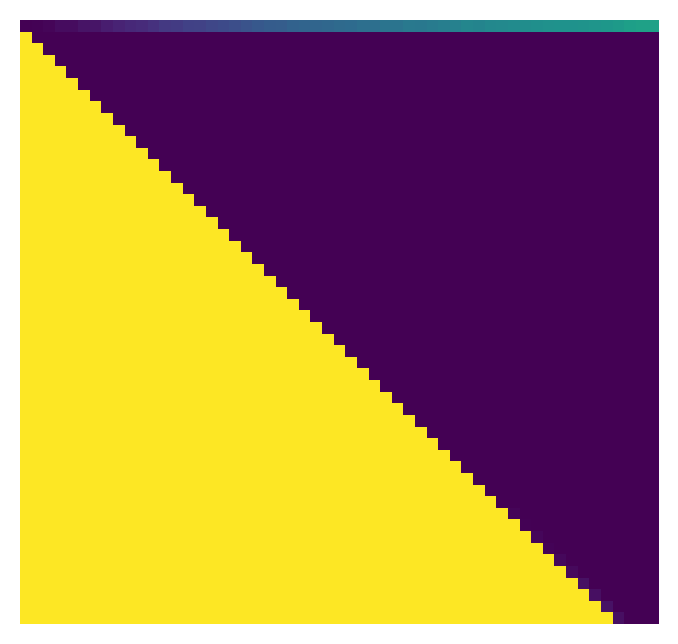

In [108]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(0, 750))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [70]:
def get_paths(device, pm):
    paths = []
    for batch in pm:
        path = find_path(device, batch)
        paths.append(path[1][None])
    paths = torch.cat(paths)
    return paths

def get_correct_multi(device, output, target, paths, pm):
    _, path_values_min = path_energy(device, pm, paths)
    match = (output == path_values_min[:,:,None]).to(torch.int)
    match = match.argmax(dim=2)
    
    correct_cum = 0
    for result, expected in zip(match, target):
        j = 0
        last_j_match = 0
        j_len = result.shape[0]
        correct = 0
        for val in expected:
            while j < j_len and val != result[j]:
                j += 1
            if j == j_len:
                j = last_j_match + 1
                #break
            else:
                correct += 1
                last_j_match = j
                
        correct_cum += correct
        
    pred = correct_cum / target.numel()
    return pred
    
def cross_entropy_verterbi(device, ce, paths):
    loss, _ = path_energy(device, ce, paths)
    loss = loss.mean()
    return loss

def get_loss_and_correct_multi(
    device, model, batch, acc_threshold=0.5):
    data, target = batch
    data, target = data.to(device), target.to(device)
    output = model(data)
    output.squeeze_()
    pm = build_path_matrix(device, output, target)
    ce = build_ce_matrix(device, output, target)
    paths = get_paths(device, pm)
    loss = cross_entropy_verterbi(device, ce, paths)
    pred = get_correct_multi(device, output, target, paths, pm)
    return loss, pred

In [71]:
def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(
            images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(
            annotations[i], (0, m_length - annotations[i].shape[0]),
            value=BETWEEN)
    if len(images) == 1:
        input, target = images[0].unsqueeze(0), torch.stack(annotations)
    else:
        input, target = torch.stack(images), torch.stack(annotations)
    input.unsqueeze_(1)
    return input, target

In [113]:
BATCH_SIZE = 32
N_EPOCHS_MULTI = 5

# for simplicity, we're training only on words of length two
sds = SimpleWordsDataset(20, length=BATCH_SIZE * NUM_BATCHES)

dataloader = torch.utils.data.DataLoader(
    sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

optimizer_b = torch.optim.Adam(
  model.parameters(), lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0.01,
  amsgrad=False, 
)

# TODO: train the model
# note: remember that our best path finding algorithm is not batched, so you'll
# need a for loop to do loss calculation. 
# This is not ideal, as for loops are very slow, but for 
# demonstration purposes it will suffice. In practice, this will be
# unusable for any real problem unless it handles batching.

# also: remember that the loss is the sum of cross_entropies along the path, not 
# energies!
loss_and_correct_func_multi = partial(get_loss_and_correct_multi, device)
train(
  N_EPOCHS_MULTI, model, dataloader, optimizer_b, None,
  loss_and_correct_func_multi)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 0 loss: 0.8137092590332031 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 1 loss: 0.23212061822414398 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 2 loss: 0.14136208593845367 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 3 loss: 0.10667231678962708 accuracy: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Iteration 4 loss: 0.10304886847734451 accuracy: 1.0


Let's check what the energy matrix looks like for the alphabet image now.

free energy is -20.214019775390625


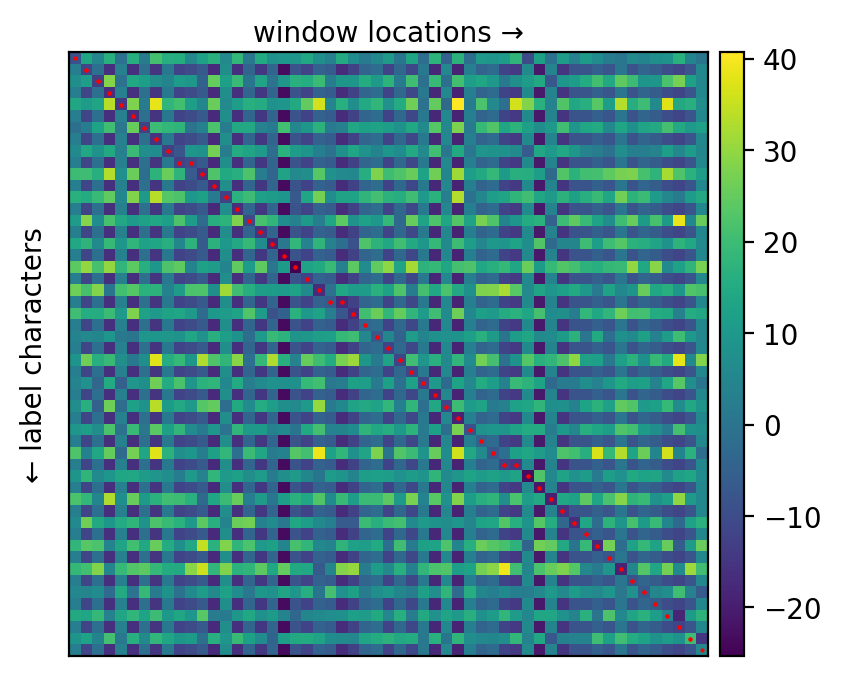

In [114]:
energies = model(alphabet.unsqueeze(0).unsqueeze(0).cuda())
targets = transform_word(string.ascii_lowercase)
pm = build_path_matrix(device, energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(device, pm[0])
points = [(i, v.item()) for i, v in enumerate(path) ]
plot_pm(pm[0].detach(), points)
print('free energy is', free_energy.item())

Explain how the free energy changed, and why.

Answer: #TODO

We can also look at raw energies output:

(-0.5, 54.5, 26.5, -0.5)

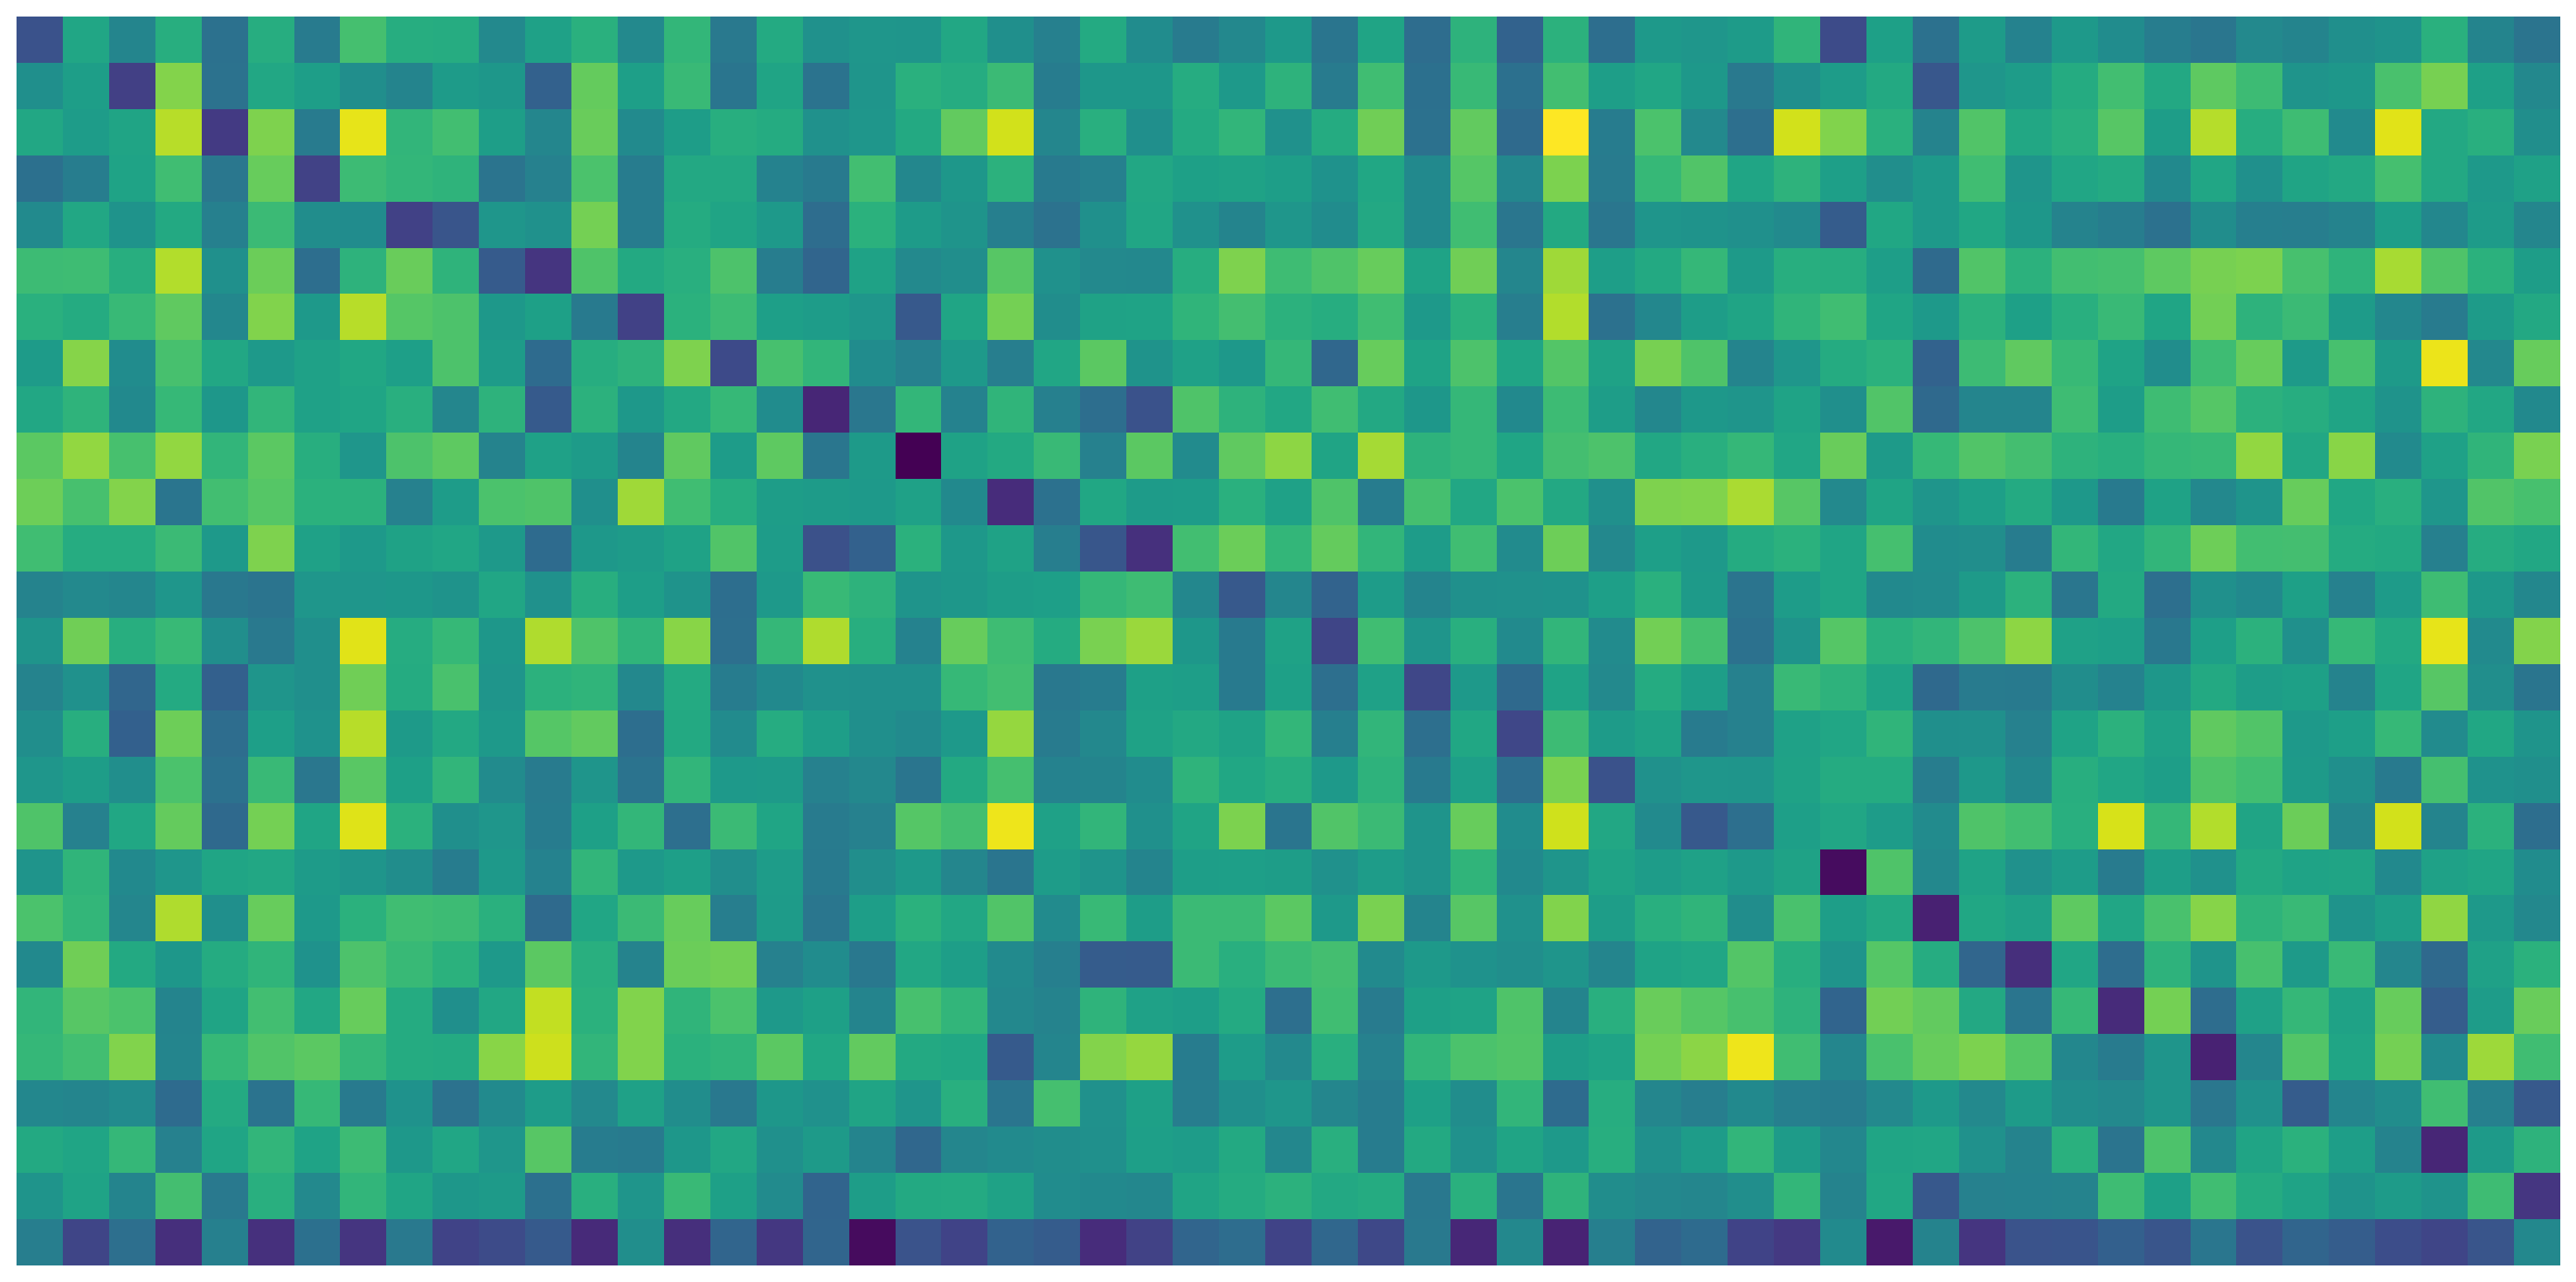

In [115]:
alphabet_energy_post_train_viterbi = model(
    alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

How does this compare to the energies we had after training only on one-character dataset?

Answer: #TODO

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies. 

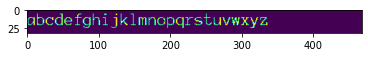

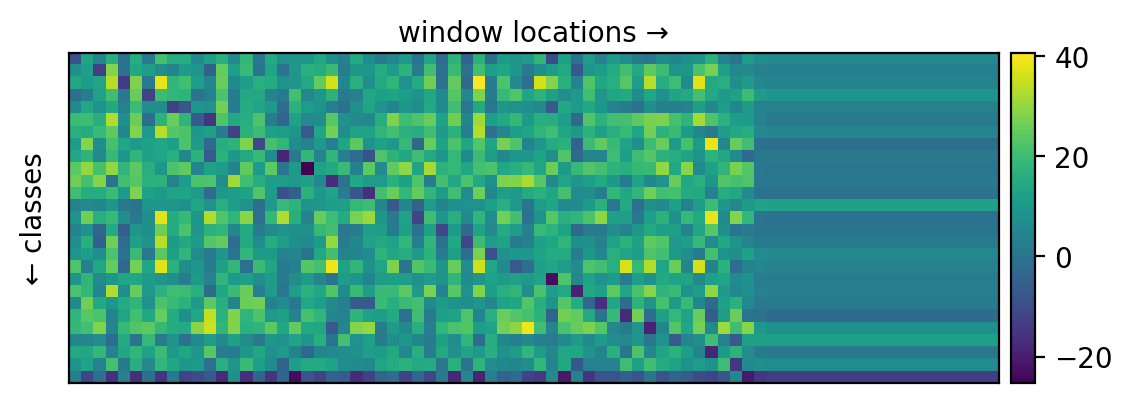

In [116]:
img = sds.draw_text('scooby doo and the gang')
img = sds.draw_text(string.ascii_lowercase)
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

You should see some characters light up. Now, let's implement a simple decoding algorithm. To decode, first we want to get most likely classes for all energies, and then do two things:
1. segment strings using the divisors (our special character with index 26), and for each segment replace it with the most common character in that segment. Example: aaab_bab_ -> a_b. If some characters are equally common, you can pick random.
2. remove all special divisor characters: a_b -> ab


In [117]:
def indices_to_str(indices):
    # inputs: indices - a tensor of most likely class indices
    # outputs: decoded string
    ret = ''
    tmp = ''
    ord_a = ord('a')
    for num in indices:
        val = num.item()
        if val != 26:
            tmp += chr(val + ord_a)
        elif tmp:
            ret += max(tmp, key=tmp.count)
            tmp = ''

    return ret        
    
    
min_indices = energies[0].argmin(dim=-1)
print(indices_to_str(min_indices))

abcdefghijklmnopqrstuvwxyz
